<a href="https://colab.research.google.com/github/Max1897/ECE7363_project/blob/main/src/ECE7363_ARIMA_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsforecast

In [2]:

import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from tqdm import tqdm
import pandas as pd
import time

from datetime import datetime


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

work_dir = "/content/drive/MyDrive/Colab Notebooks/data/Network_proj/"

Mounted at /content/drive


# **Process Data**  

In [56]:
#Read files
train_data = np.loadtxt(work_dir + "GEANT_train.txt",dtype = float)
test_data = np.loadtxt(work_dir + "GEANT_test.txt",dtype = float)
All = np.vstack((train_data,test_data))

In [5]:
#The originate unit is 15min, the second parameter means add up "addup" units. (4 means a hour)
def change_granularity(data, addup = 1):
  data_length = data.shape[0]
  Temp = np.sum(data[0:addup],axis = 0)
  itr_end = data_length // addup
  for i in tqdm(range(1,itr_end)):
    temp0 = np.sum(data[i*addup:i*addup+addup],axis = 0)
    Temp = np.vstack((Temp,temp0))
  
  return Temp

### Delete the demands column where source and target are the same

In [57]:
num_nodes = 22
ind = []
for i in range(num_nodes):
  for j in range(num_nodes):
    if i == j :ind.append(i*num_nodes + j)

mask = np.ones((num_nodes ** 2), dtype = bool)
mask[[ind]] = False
All = All[:,mask]


<ipython-input-57-0c439d3be0f2>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[[ind]] = False


### Choose granularity

In [58]:
gran_addup = 2
All = change_granularity(All,gran_addup)

100%|██████████| 5385/5385 [00:11<00:00, 488.38it/s]


###Getting ready for ARIMA

In [59]:
data_set = All.T

#**Model settup**

In [60]:
AR = []
for i in tqdm(range(462)):
  ar = AutoARIMA()
  AR.append(ar)


100%|██████████| 462/462 [00:00<00:00, 316215.48it/s]


#**Model training**

In [65]:
start = 800
end = 1300

In [66]:
for i in tqdm(range(462)):
  ar = AR[i]
  ar.fit(data_set[i][start:end])

100%|██████████| 462/462 [03:51<00:00,  1.99it/s]


#**Prediction**

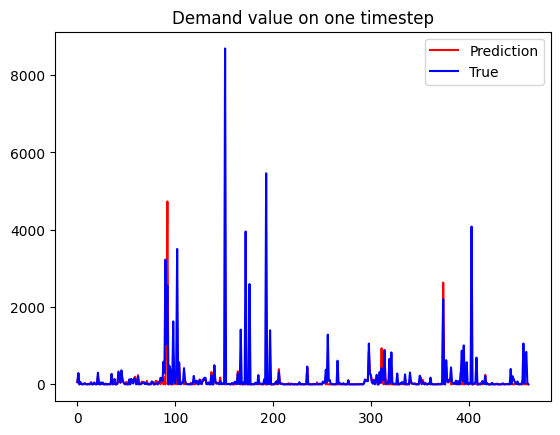

In [69]:
FC = []
for i in range(462):
  fc = AR[i].predict(h = 1,level = [90])
  FC.append(fc["mean"])
FC = np.array(FC)
true = data_set[:,end]
  
plt.plot(FC, color = 'red', label = 'Prediction')
plt.plot(true, color = 'blue', label = "True")
plt.title("Demand value on one timestep")
plt.legend()
plt.show()

#**Output to AMPL**

In [ ]:
def output_to_AMPL(demands,dir):
  
  demand_matrix = []
  for i in range(1,23):
    line0 = repr(i) 
    for j in range(1,23):
      if i == j: continue
      line1 = line0 + " " + repr(j)
      demand_matrix.append(line1)


  f = open(dir,'w')
  for i,d in enumerate(np.squeeze(demands)):
    if d < 0: d = 0.0
    demand_matrix[i] = repr(i+1) + " "+ demand_matrix[i] + " " + repr(d) + "\n"
    f.write(demand_matrix[i])
  f.close()

  return demand_matrix

now = datetime.now()
date_time = now.strftime("%d%H%M")
pred_dir = work_dir + 'AMPL demands/' + date_time + "ARIMA_pred.txt"
true_dir = work_dir + 'AMPL demands/' + date_time + "ARIMA_true.txt"
output_to_AMPL(FC,pred_dir)
output_to_AMPL(true,true_dir)